In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cervical-cancer-csv/cervical_cancer.csv


**Cervical Cancer Prediction with XGBoost Model**

For this notebook, I will build and XGBoost classifier to predict whether a person has a risk of having cervical cancer. Cervical cancer kills about 4,000 women in the U.S. and about 300,000 women worldwide. Data has been obtained from 858 patients and include features such as number of pregnancies, smoking habits, Sexually Transmitted Disease (STD), demographics, and historic medical records. Results have shown that High sexual activity Human papilloma virus (HPV) is one of the key factors that increases the risk of having cervical cancer. The presence of hormones in oral contraceptives, having many children, and smoking increase the risk for developing cervical cancer, particularly in women infected with HPV. Also, people with weak immune systems (HIV/AIDS) have high risk of HPV. By leveraging machine learning and AI, cervical cancer's death rate can be dramatically reduced with early detection and diagnosis. 

**Dataset Source**

The dataset was collected at the Hospital Univeritario de Caracas, Venezuela and contains demographic information, habits, and historic medical records of 858 patients. 

**Data Dictionary**

1. Age (int): Age of the patient
2. Number of sexual partners (int): Number of sexual partners
3. First sexual intercourse (age) (int): Age at first sexual intercourse
4. Num of pregnancies (int): Number of pregnancies
5. Smokes (bool): Whether the patient smokes
6. Smokes (years) (bool): Duration of smoking in years
7. Smokes (packs/year) (bool): Packs of cigarettes smoked per year
8. Hormonal Contraceptives (bool): Whether the patient uses hormonal contraceptives
9. Hormonal Contraceptives (years) (int): Duration of hormonal contraceptive use in years
10. IUD (bool): Whether the patient uses an intrauterine device (IUD) for birth control
11. IUD (years) (int): Duration of IUD use in years
12. STDs (bool): Whether the patient has had sexually transmitted diseases (STDs)
13. STDs (number) (int): Number of STDs the patient has had 
14. STDs (bool): Whether the patient has had condylomatosis
15. STDs condylomatosis (bool): Whether the patient has had cervical condylomatosis
16. STDs condylomatosis (bool): Whether the patient has had vaginal condylomatosis
17. STDs condylomatosis (bool): Whether the patient has had vulvo-perineal condylomatosis
18. STDs (bool): Whether the patient has had syphilis
19. STDs inflammatory disease (bool): Whether the patient has had pelvic inflammatory disease
20. STDs herpes (bool): Whether the patient has had genital herpes
21. STDs contagiosum (bool): Whether the patient has had molluscum contagiosum
22. STDs (bool): Whether the patient has had AIDS
23. STDs (bool): Whether the patient has had HIV
24. STDs B (bool): Whether the patient has had Hepatitis B
25. STDs (bool): Whether the patient has had HPV
26. STDs: Number of diagnosis (int): Number of STD diagnoses
27. STDs: Time since first diagnosis (int): Time since the first STD diagnosis
28. STDs: Time since last diagnosis (int): Time since the last STD diagnosis
29. Dx (bool): Whether the patient has been diagnosed with cancer
30. Dx (bool): Whether the patient has been diagnosed with Cervical Intraepithelial Neoplasia (CIN)
31. Dx (bool): Whether the patient has been diagnosed with HPV
32. Dx (bool): General diagnosis status
33. Hinselmann (bool): Target variable - A colposcopy is a procedure in which doctors examine the cervix
34. Schiller (bool): Target variable - Schiller's Iodine test is used for cervical cancer diagnosis
35. Cytology (bool): Target variable - Cytology is the exam of a single cell type used for cancer screening
36. Biopsy (bool): Target variable - Biopsy is performed by removing a piece of tissue and examining it under a microscope. Biopsy is the main way doctors diagnose most types of cancer

For this project, my main focus is going to be to train and XGBoost algorithm to predict the Biopsy variable (any of the four target features would work). 

**XGBoost**

XGBoost (Extreme Gradient Boosting), which sequentially builds models by correcting the errors of the previous models, is known for its high performance and efficiency in machine learning competitions and practical applications. It consistently outperforms other algorithms in terms of speed and accuracy. For a critical application like cervical cancer prediction, where accuracy can significantly impact early detection and treatment, XGBoost's superior performance is a major advantage and it has proven to show high computational efficiency.

**Tasks**

I will now proceed to implement the XGBoost classifier for cervical cancer prediction, starting with data loading, preprocessing and exploratory data analysis, data visualizations, prepare the data before model training, and then model training and evaluation. Let's begin by importing the necessary libraries and loading the dataset.


In [40]:
# Import necessary libraries and packages
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load in the dataset
df= pd.read_csv('/kaggle/input/cervical-cancer-csv/cervical_cancer.csv')

In [5]:
# View the dataset
df.head(10)

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0
5,42,3.0,23.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
6,51,3.0,17.0,6.0,1.0,34.0,3.4,0.0,0.0,1.0,...,?,?,0,0,0,0,1,1,0,1
7,26,1.0,26.0,3.0,0.0,0.0,0.0,1.0,2.0,1.0,...,?,?,0,0,0,0,0,0,0,0
8,45,1.0,20.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,1,0,1,1,0,0,0,0
9,44,3.0,15.0,?,1.0,1.266972909,2.8,0.0,0.0,?,...,?,?,0,0,0,0,0,0,0,0


In [6]:
# Explore the data
df.shape

(858, 36)

- Data has been obtained from 858 patients. 

In [7]:
# Explore the data
df.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')

In [9]:
# Renaming all columns to snake_case
df.columns= [
    'age', 'number_of_sexual_partners', 'first_sexual_intercourse', 'num_of_pregnancies',
    'smokes', 'smokes_years', 'smokes_packs_per_year', 'hormonal_contraceptives',
    'hormonal_contraceptives_years', 'iud', 'iud_years', 'stds', 'stds_number',
    'stds_condylomatosis', 'stds_cervical_condylomatosis', 'stds_vaginal_condylomatosis',
    'stds_vulvo_perineal_condylomatosis', 'stds_syphilis', 'stds_pelvic_inflammatory_disease',
    'stds_genital_herpes', 'stds_molluscum_contagiosum', 'stds_aids', 'stds_hiv',
    'stds_hepatitis_b', 'stds_hpv', 'stds_number_of_diagnosis', 'stds_time_since_first_diagnosis',
    'stds_time_since_last_diagnosis', 'dx_cancer', 'dx_cin', 'dx_hpv', 'dx',
    'hinselmann', 'schiller', 'citology', 'biopsy'
]

In [10]:
# Explore the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   age                                 858 non-null    int64 
 1   number_of_sexual_partners           858 non-null    object
 2   first_sexual_intercourse            858 non-null    object
 3   num_of_pregnancies                  858 non-null    object
 4   smokes                              858 non-null    object
 5   smokes_years                        858 non-null    object
 6   smokes_packs_per_year               858 non-null    object
 7   hormonal_contraceptives             858 non-null    object
 8   hormonal_contraceptives_years       858 non-null    object
 9   iud                                 858 non-null    object
 10  iud_years                           858 non-null    object
 11  stds                                858 non-null    object

In [12]:
# View summary statistics
df.describe()

,age,stds_number_of_diagnosis,dx_cancer,dx_cin,dx_hpv,dx,hinselmann,schiller,citology,biopsy
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,26.820513,0.087413,0.020979,0.010490,0.020979,0.027972,0.040793,0.086247,0.051282,0.064103
std,8.497948,0.302545,0.143398,0.101939,0.143398,0.164989,0.197925,0.280892,0.220701,0.245078
min,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,84.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Summary Statistics Analysis**

The summary statistics provide several key insights into the dataset. The patients' ages range from 13 to 84 years, with an average age of approximately 26.82 years. This indicates a relatively young patient group, with a median age of 25 years and most patients falling between 20 and 32 years. The standard deviation of 8.50 reflects a wide age spread.

When examining the number of STD diagnoses, it is evident that most patients have not been diagnosed with an STD, as both the median and the 75th percentile values are 0. The average number of STD diagnoses is 0.087, with the highest number being 3. This suggests that STD diagnoses are relatively rare among the patients in this dataset.

The binary diagnosis columns (Dx_Cancer, Dx_CIN, Dx_HPV, and Dx) show very low mean values, indicating that these conditions are uncommon. Specifically, 2.10% of patients are diagnosed with cancer, 1.05% with CIN, 2.10% with HPV, and 2.80% have some general diagnosis.

The target variable, biopsy, is also binary, with an average value of 0.064, indicating that only about 6.41% of the patients have a positive biopsy result. This shows a significant imbalance in the target variable, which will require techniques such as stratified sampling, adjusting class weights, or employing oversampling/undersampling methods to handle effectively.

The other target variables related to diagnostic tests (Hinselmann, Schiller, and Citology) also show low incidence rates, with positive results in 4.08%, 8.62%, and 5.13% of cases, respectively. These results suggest that positive findings from these diagnostic tests are relatively rare and may be used to confirm initial suspicions rather than as routine screening tests.

In summary, the dataset is characterized by a young patient group with a low incidence of diagnoses for cancer and STDs. The significant imbalance in the target variable, biopsy, highlights the need for careful handling to ensure effective model training. Additionally, the rarity of positive diagnostic test results suggests that these tests are likely used selectively for further investigation rather than for routine screening.

In [13]:
# Check for missing values
df.isnull().sum()

age                                   0
number_of_sexual_partners             0
first_sexual_intercourse              0
num_of_pregnancies                    0
smokes                                0
smokes_years                          0
smokes_packs_per_year                 0
hormonal_contraceptives               0
hormonal_contraceptives_years         0
iud                                   0
iud_years                             0
stds                                  0
stds_number                           0
stds_condylomatosis                   0
stds_cervical_condylomatosis          0
stds_vaginal_condylomatosis           0
stds_vulvo_perineal_condylomatosis    0
stds_syphilis                         0
stds_pelvic_inflammatory_disease      0
stds_genital_herpes                   0
stds_molluscum_contagiosum            0
stds_aids                             0
stds_hiv                              0
stds_hepatitis_b                      0
stds_hpv                              0


- Even though there aren't any missing values, if we look above a little at the df.head(10) code results, we can see that there are lot of '?' filled in for values. This is essentially because a lot of these patients did not want to disclose that certain type of information. So I will proceed to replace the question marks with NaN (Not A Number) to improve data integrity and standardize the missing values. It's also better because many machine learning algorithms have mechanisms to handle 'NaN' values. 

In [15]:
# Change '?' to 'NaN' and view the dataset
df= df.replace('?', np.nan)
df.head(10)

,age,number_of_sexual_partners,first_sexual_intercourse,num_of_pregnancies,smokes,smokes_years,smokes_packs_per_year,hormonal_contraceptives,hormonal_contraceptives_years,iud,...,stds_time_since_first_diagnosis,stds_time_since_last_diagnosis,dx_cancer,dx_cin,dx_hpv,dx,hinselmann,schiller,citology,biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
5,42,3.0,23.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
6,51,3.0,17.0,6.0,1.0,34.0,3.4,0.0,0.0,1.0,...,NaN,NaN,0,0,0,0,1,1,0,1
7,26,1.0,26.0,3.0,0.0,0.0,0.0,1.0,2.0,1.0,...,NaN,NaN,0,0,0,0,0,0,0,0
8,45,1.0,20.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,1,0,1,1,0,0,0,0
9,44,3.0,15.0,NaN,1.0,1.266972909,2.8,0.0,0.0,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0


In [16]:
# Detect missing values. True= 'Nan', False= otherwise
df.isnull()

,age,number_of_sexual_partners,first_sexual_intercourse,num_of_pregnancies,smokes,smokes_years,smokes_packs_per_year,hormonal_contraceptives,hormonal_contraceptives_years,iud,...,stds_time_since_first_diagnosis,stds_time_since_last_diagnosis,dx_cancer,dx_cin,dx_hpv,dx,hinselmann,schiller,citology,biopsy
0,False,False,False,False,False,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,False,False,False,False,False,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
854,False,False,False,False,False,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
855,False,False,False,False,False,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
856,False,False,False,False,False,False,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False


<Axes: >

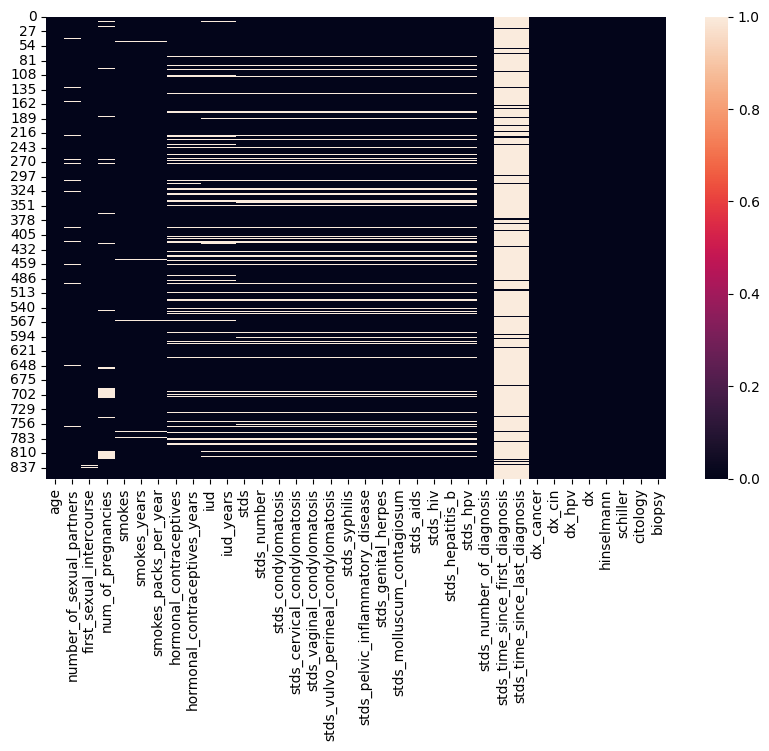

In [17]:
# Heatmap to visualize how many null elements are present in the dataset
plt.figure(figsize= (10,6))
sns.heatmap(df.isnull())

**Heatmap Analysis**

From the heatmap, it is evident that the 'stds_time_since_first_diagnosis' and the 'stds_time_since_last_diagnosis' columns have a significant amount of null values. I will now proceed to drop them

In [18]:
# Drop columns with significant null values
df= df.drop(columns= ['stds_time_since_first_diagnosis', 'stds_time_since_last_diagnosis'])

In [20]:
# Confirming dropped columns
df.shape

(858, 34)

Perfect, now there are 34 columns.

If we refer to the df.info() results above, it is clear that there are numerous columns with 'object' data types. Since these columns are currently non-numeric, I cannot derive meaningful statistics from them. Therefore, I will proceed to convert these columns to numeric data types. This conversion is crucial because it enables me to perform statistical analysis, visualizations, and it also prepares the data for the machine learning model, which require numeric inputs for accurate computations.

In [21]:
# Convert 'object' data types to numeric data types and the confirm changes
df= df.apply(pd.to_numeric)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age                                 858 non-null    int64  
 1   number_of_sexual_partners           832 non-null    float64
 2   first_sexual_intercourse            851 non-null    float64
 3   num_of_pregnancies                  802 non-null    float64
 4   smokes                              845 non-null    float64
 5   smokes_years                        845 non-null    float64
 6   smokes_packs_per_year               845 non-null    float64
 7   hormonal_contraceptives             750 non-null    float64
 8   hormonal_contraceptives_years       750 non-null    float64
 9   iud                                 741 non-null    float64
 10  iud_years                           741 non-null    float64
 11  stds                                753 non-n

In [22]:
# Get summary statistics 
df.describe()

,age,number_of_sexual_partners,first_sexual_intercourse,num_of_pregnancies,smokes,smokes_years,smokes_packs_per_year,hormonal_contraceptives,hormonal_contraceptives_years,iud,...,stds_hpv,stds_number_of_diagnosis,dx_cancer,dx_cin,dx_hpv,dx,hinselmann,schiller,citology,biopsy
count,858.000000,832.000000,851.000000,802.000000,845.000000,845.000000,845.000000,750.000000,750.000000,741.000000,...,753.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,26.820513,2.527644,16.995300,2.275561,0.145562,1.219721,0.453144,0.641333,2.256419,0.112011,...,0.002656,0.087413,0.020979,0.010490,0.020979,0.027972,0.040793,0.086247,0.051282,0.064103
std,8.497948,1.667760,2.803355,1.447414,0.352876,4.089017,2.226610,0.479929,3.764254,0.315593,...,0.051503,0.302545,0.143398,0.101939,0.143398,0.164989,0.197925,0.280892,0.220701,0.245078
min,13.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,2.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,2.000000,17.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,3.000000,18.000000,3.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,84.000000,28.000000,32.000000,11.000000,1.000000,37.000000,37.000000,1.000000,30.000000,1.000000,...,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Updated Summary Statistics Analysis**

From the updated summary statistics, the dataset reveals various important characteristics about the patients and their health behaviors. The number of sexual partners among patients ranges from 1 to 28, with an average of approximately 2.53 partners and a standard deviation of 1.67. This indicates that while most patients have between 1 and 3 sexual partners, there are a few outliers with significantly higher numbers. Regarding the age of first sexual intercourse, the mean age is 17 years, with a range from 10 (oh my!) to 32 years (oh my?), and a standard deviation of 2.80 years, showing that the majority of patients had their first sexual experience between 15 and 18 years old.

In terms of pregnancies, patients have had between 0 and 11 pregnancies, with a mean of 2.28 and a standard deviation of 1.45. Most patients have had between 1 and 3 pregnancies, although there are instances of patients with no pregnancies or as many as 11. Smoking habits show that 14.6% of the patients smoke, with the duration of smoking ranging from 0 to 37 years and an average of 1.22 years, indicating that many patients do not smoke or have smoked for only a short duration, but a few have a long history of smoking.

The number of packs smoked per year follows a similar pattern, with an average of 0.45 packs/year and a range from 0 to 37 packs/year. This suggests that while most patients have low or no smoking pack-year history, a small number of patients have smoked heavily. Regarding hormonal contraceptives, 64.1% of the patients use them, with usage duration ranging widely from 0 to 30 years and an average of 2.26 years. This shows a significant portion of patients using hormonal contraceptives, but with considerable variation in the duration of use.

For intrauterine device (IUD) usage, 11.2% of the patients use an IUD, indicating it is less common among the patient group. The data also shows that 0.27% of patients have been diagnosed with HPV, which is relatively rare in this dataset. 

Despite the insights provided, it is important to note that several columns still have missing values, such as number_of_sexual_partners, first_sexual_intercourse, smokes_years, smokes_packs_per_year, hormonal_contraceptives_years, and others. These missing values need to be addressed to ensure the dataset's completeness and reliability for further analysis. I will proceed to replace these missing values with the mean, which is a common imputation technique. 

In [23]:
# Replace the null values with mean and verify changes
df= df.fillna(df.mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age                                 858 non-null    int64  
 1   number_of_sexual_partners           858 non-null    float64
 2   first_sexual_intercourse            858 non-null    float64
 3   num_of_pregnancies                  858 non-null    float64
 4   smokes                              858 non-null    float64
 5   smokes_years                        858 non-null    float64
 6   smokes_packs_per_year               858 non-null    float64
 7   hormonal_contraceptives             858 non-null    float64
 8   hormonal_contraceptives_years       858 non-null    float64
 9   iud                                 858 non-null    float64
 10  iud_years                           858 non-null    float64
 11  stds                                858 non-n

<Axes: >

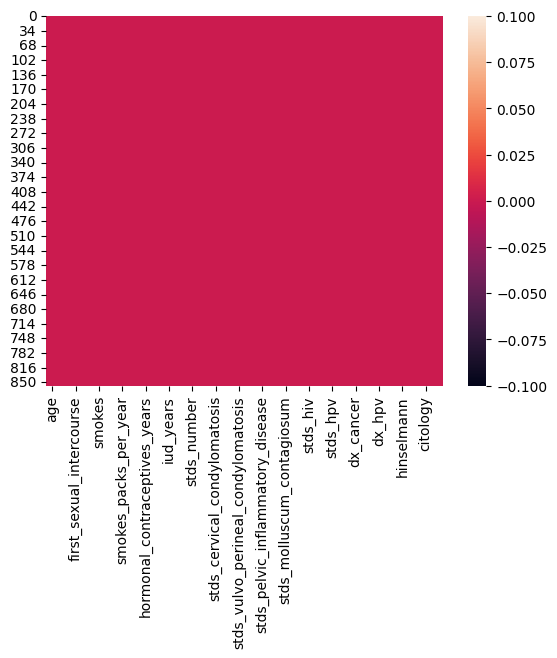

In [24]:
# Double confirming with heatmap
sns.heatmap(df.isnull())

In [37]:
# Correlation matrix of the features
corr_matrix= df.corr()
print(corr_matrix)

                                         age  number_of_sexual_partners  \
age                                 1.000000                   0.084896   
number_of_sexual_partners           0.084896                   1.000000   
first_sexual_intercourse            0.369168                  -0.147937   
num_of_pregnancies                  0.526137                   0.076719   
smokes                              0.055813                   0.238078   
smokes_years                        0.217349                   0.177117   
smokes_packs_per_year               0.131180                   0.175153   
hormonal_contraceptives             0.065624                   0.006342   
hormonal_contraceptives_years       0.277181                   0.018552   
iud                                 0.267662                   0.030005   
iud_years                           0.205886                   0.004215   
stds                                0.010017                   0.053754   
stds_number              

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'number_of_sexual_partners'}>,
        <Axes: title={'center': 'first_sexual_intercourse'}>,
        <Axes: title={'center': 'num_of_pregnancies'}>,
        <Axes: title={'center': 'smokes'}>,
        <Axes: title={'center': 'smokes_years'}>],
       [<Axes: title={'center': 'smokes_packs_per_year'}>,
        <Axes: title={'center': 'hormonal_contraceptives'}>,
        <Axes: title={'center': 'hormonal_contraceptives_years'}>,
        <Axes: title={'center': 'iud'}>,
        <Axes: title={'center': 'iud_years'}>,
        <Axes: title={'center': 'stds'}>],
       [<Axes: title={'center': 'stds_number'}>,
        <Axes: title={'center': 'stds_condylomatosis'}>,
        <Axes: title={'center': 'stds_cervical_condylomatosis'}>,
        <Axes: title={'center': 'stds_vaginal_condylomatosis'}>,
        <Axes: title={'center': 'stds_vulvo_perineal_condylomatosis'}>,
        <Axes: title={'center': 'stds_syphilis'}>],
    

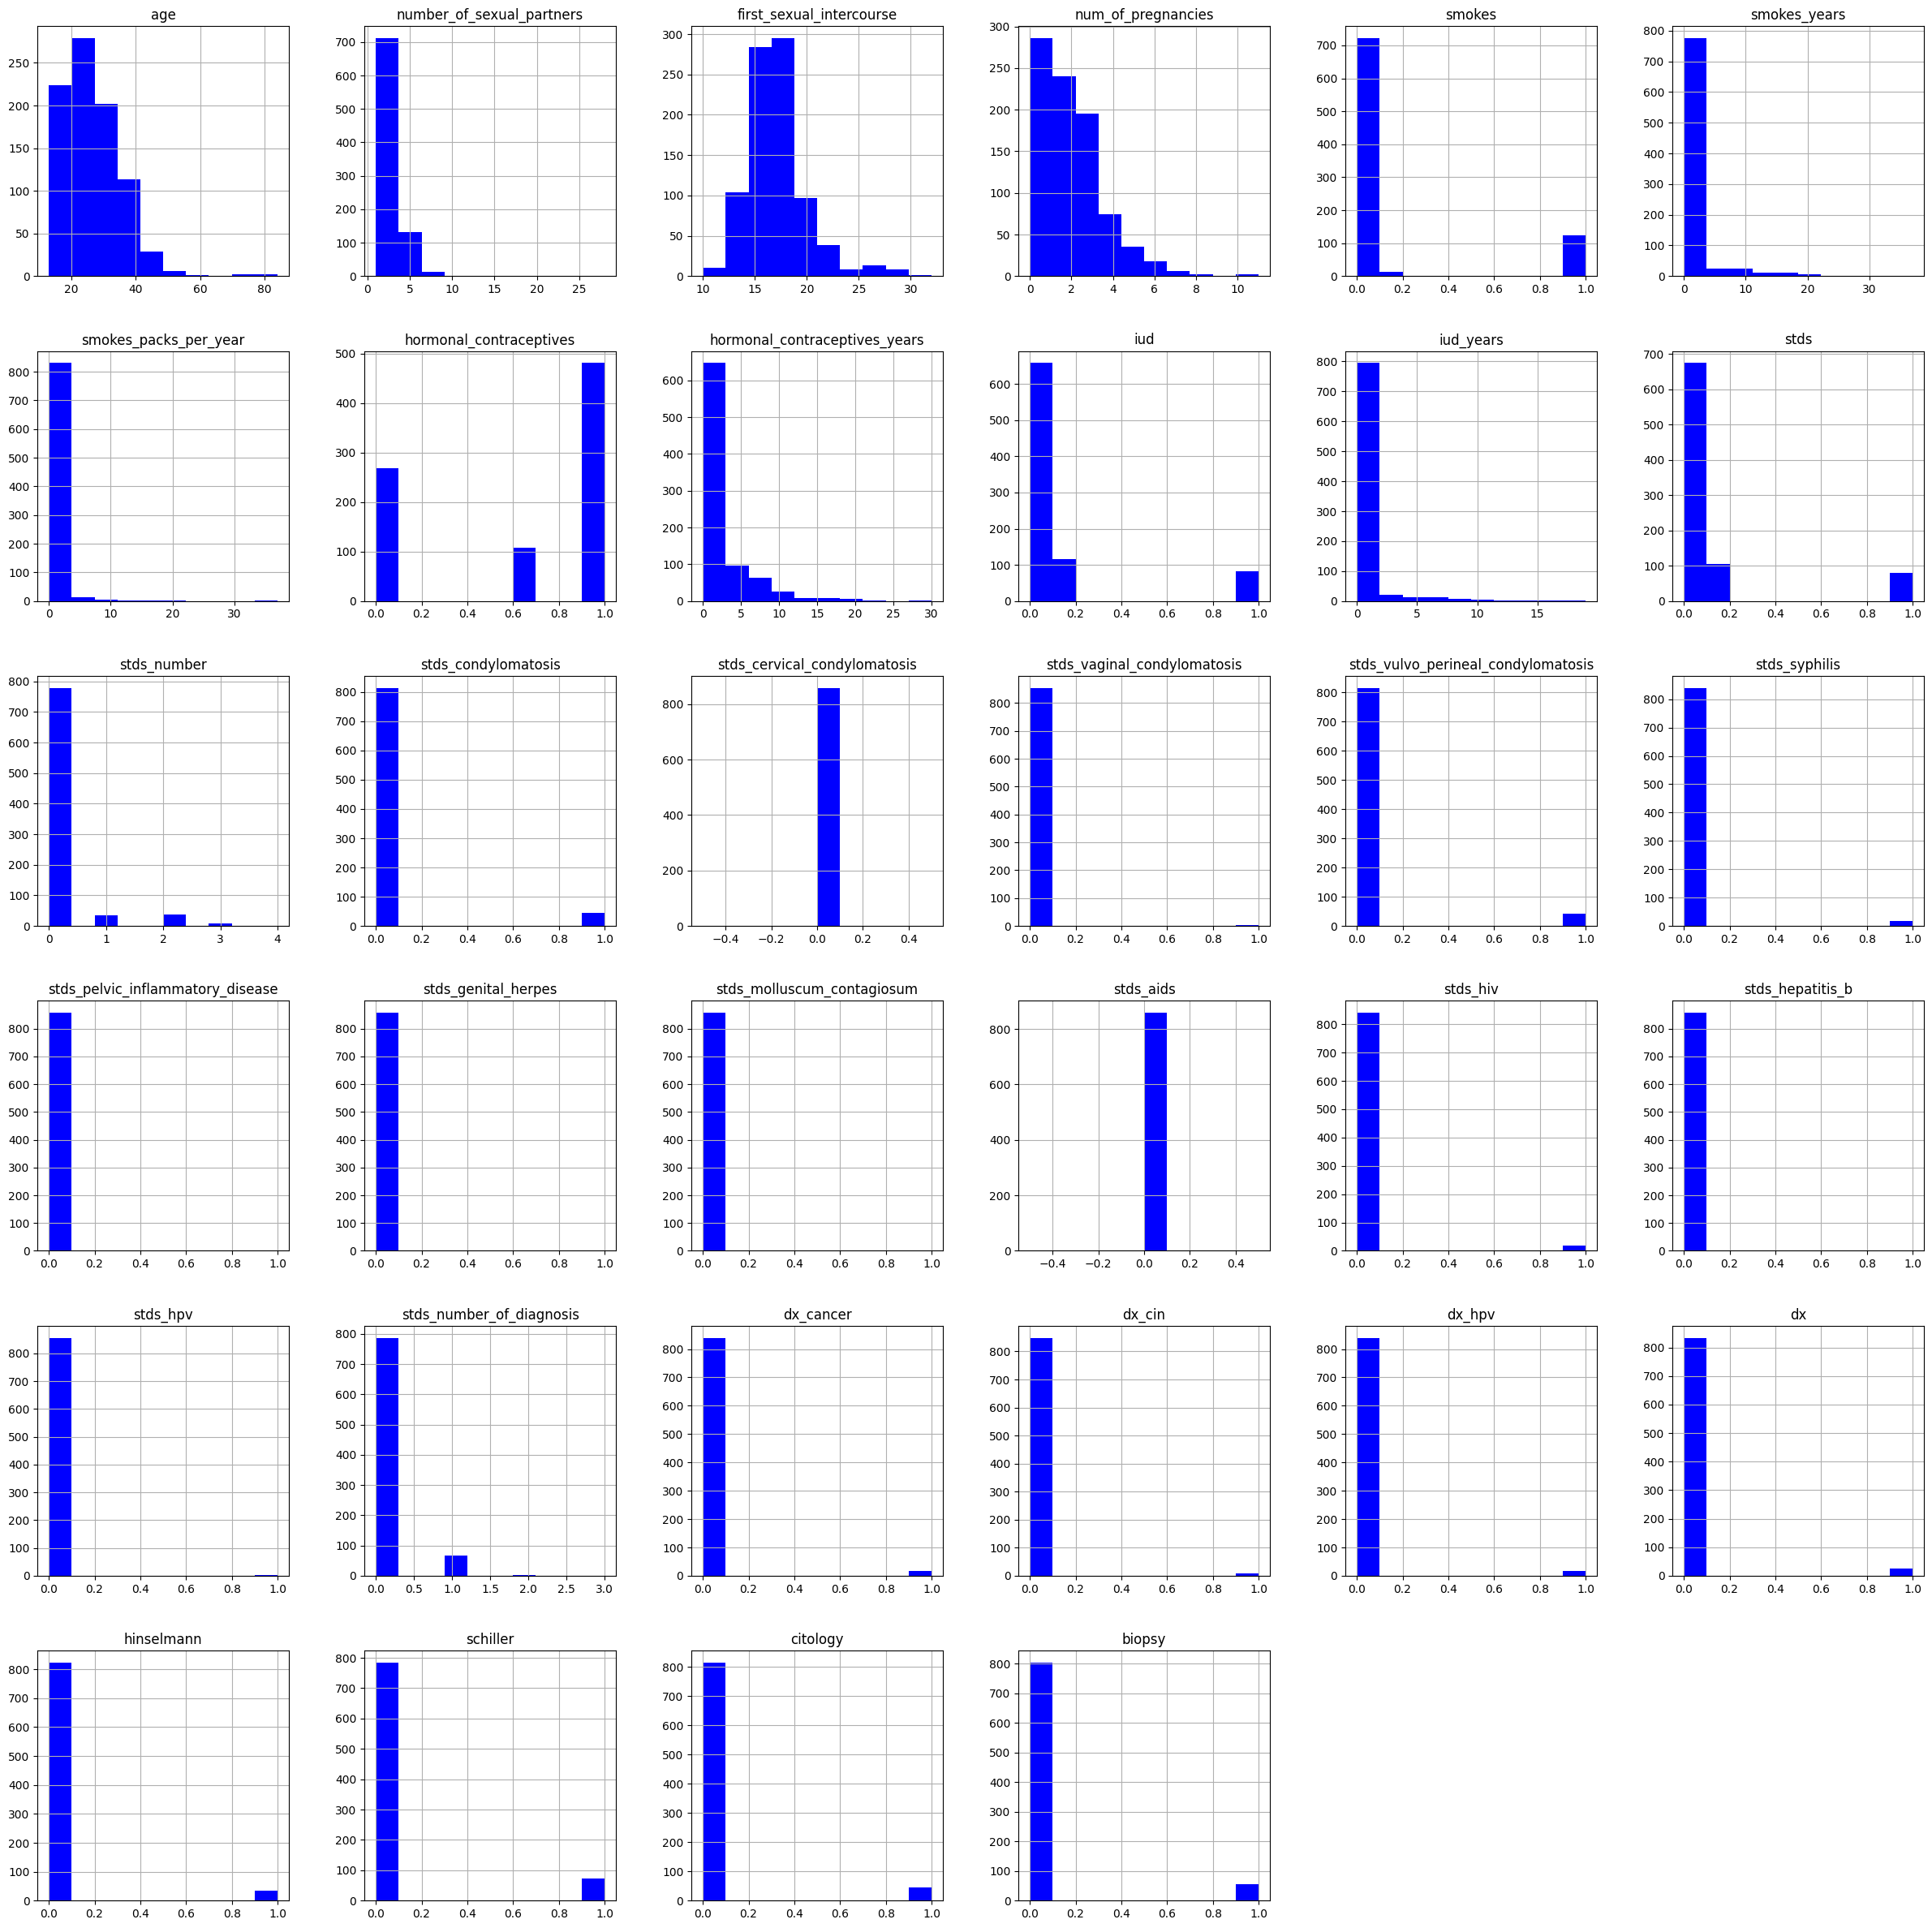

In [30]:
# Plot histograms
df.hist(bins= 10, figsize= (30,30), color= 'b')

In [32]:
# Define features and target variable
X= df.drop(columns= ['biopsy'])
y= df['biopsy']
y.shape

(858,)

In [33]:
# Confirming features shape
X.shape

(858, 33)

In [34]:
# Convert features and target feature to 'float32' to improve computation efficiency
X= X.astype(np.float32)
y= y.astype(np.float32)

**Training Set, Validation Set & Test Set**

I will now proceed to split the dataset into three subsets: the training set, the validation set, and the test set. Each of these subsets serves a distinct purpose in the machine learning pipeline, ensuring that I develop a robust and generalizable model.

The training set is used to train the machine learning model. This subset of the data allows the model to learn the underlying patterns and relationships within the data. The model adjusts its parameters based on this subset to minimize the error between its predictions and the actual outcomes.

The validation set is used to fine-tune the model's hyperparameters and evaluate its performance during the training process. By setting aside a portion of the data as the validation set, I can test how well the model performs on unseen data that it was not trained on. This step helps in selecting the best model and preventing overfitting, where the model performs well on the training data but poorly on new, unseen data.

Finally, the test set is used to evaluate the model's performance after it has been trained and fine-tuned. This subset represents completely unseen data that was not used during the training or validation phases. The test set provides an unbiased evaluation of the model's ability to generalize to new data. It acts as the final check to ensure that the model performs well not only on the data it has seen during training and validation but also on entirely new data. By evaluating the model on the test set, I can confidently assess its real-world performance and reliability

In [35]:
# Split the data into training, validation and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state= 42)
X_test, X_val, y_test, y_val= train_test_split(X_test, y_test, test_size= 0.5, random_state= 42)

**Standard Scaler**

In the following code block, I standardize the features using StandardScaler from sklearn.preprocessing, which ensures each feature has a mean of 0 and a standard deviation of 1. This process helps improve the performance and convergence speed of many machine learning algorithms.

First, I create an instance of StandardScaler with scaler = StandardScaler(). Then I fit the scaler on the training data and transform it in one step. This computes the mean and standard deviation for each feature in the training set and applies the transformation.

Then, I use the same scaler to transform the validation and test data. By fitting the scaler only on the training data and then applying it to the validation and test sets, I ensure that all data is standardized consistently, preventing data leakage and maintaining the integrity of the evaluation process. This standardization helps the model learn more effectively and ensures fair comparisons across different datasets.

In [36]:
# Initialize the StandardScaler
scaler= StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train_scaled= scaler.fit_transform(X_train)

# Transform the validation and test data using the same scaler
X_val_scaled= scaler.transform(X_val)
X_test_scaled= scaler.transform(X_test)

In [45]:
# Initialize the XGBClassifier with specified learning rate
model=  XGBClassifier(learning_rate= 0.1, max_depth= 5, n_estimators= 100, random_state= 42)

In [47]:
# Fit the model
model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [48]:
# Make predictions on the valdiation set
y_val_pred= model.predict(X_val_scaled)

In [50]:
# Evaluate the model on the validation set
accuracy= accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy}')

Validation Accuracy: 0.9418604651162791


- The validation accuracy of 94.19% indicates that the model performs very well on the validation set, correctly predicting the target variable for approximately 94% of the validation samples. This high accuracy suggests that the model has effectively learned from the training data and generalizes well to unseen data in the validation set

In [58]:
# Classification Report of the validation set
cr= classification_report(y_val, y_val_pred)
print(f'Classification Report:\n', cr)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97        82
         1.0       0.33      0.25      0.29         4

    accuracy                           0.94        86
   macro avg       0.65      0.61      0.63        86
weighted avg       0.93      0.94      0.94        86



**Classification Report for the Validation Set**

The classification report for the validation set shows that the model performs very well in identifying the negative class (class 0), with a precision of 0.96 and a recall of 0.98, resulting in a high F1-score of 0.97. This indicates that the model correctly identifies 96% of the instances it predicts as negative and successfully captures 98% of all actual negative instances. However, the performance for the positive class (class 1) is notably lower, with a precision of 0.33 and a recall of 0.25, leading to an F1-score of 0.29. This suggests that the model struggles to correctly identify positive cases, as only 33% of the predicted positive instances are correct, and it captures only 25% of the actual positive instances. Despite this, the overall accuracy of the model is high at 94%, mainly due to the larger number of negative instances. The macro average F1-score of 0.63 and the weighted average F1-score of 0.94 reflect the model's strong performance on the more prevalent negative class, but also highlight the need for improvement in detecting the minority positive class.

I would say that the reason the performance metrics for class 1 are lower is likely due to the imbalance in the dataset, with class 1 having much fewer examples to train on.

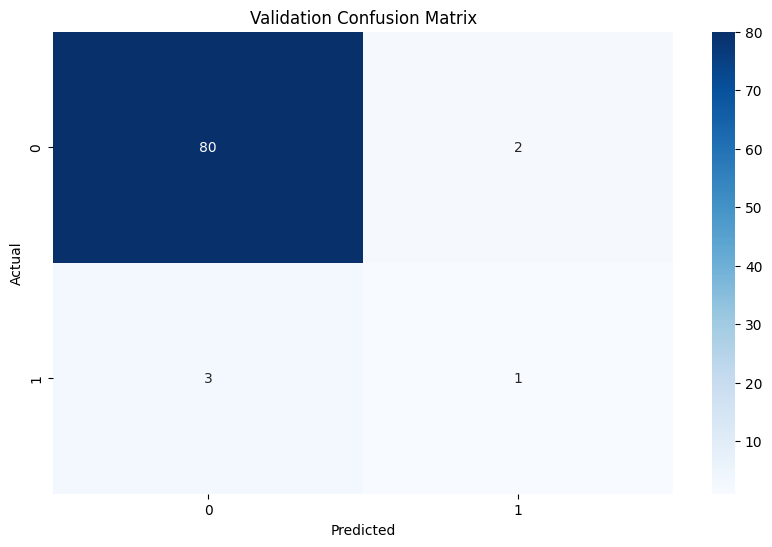

In [55]:
# Plot Confusion Matrix for validation set
val_cm= confusion_matrix(y_val, y_val_pred)

plt.figure(figsize= (10,6))
sns.heatmap(val_cm, annot= True, fmt= 'd', cmap= 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.show()

**Validation Confusion Matrix**

The validation confusion matrix reveals that the model performs well in predicting the negative class but struggles with the positive class. Specifically, the model correctly predicts 80 out of 82 negative instances (true negatives) and misclassifies 2 as positive (false positives). For the positive class, the model correctly identifies only 1 out of 4 instances (true positives) and incorrectly classifies 3 as negative (false negatives). This indicates that while the model is highly accurate in identifying negatives, it has difficulty detecting positives, likely due to the class imbalance where there are significantly fewer positive examples to learn from.

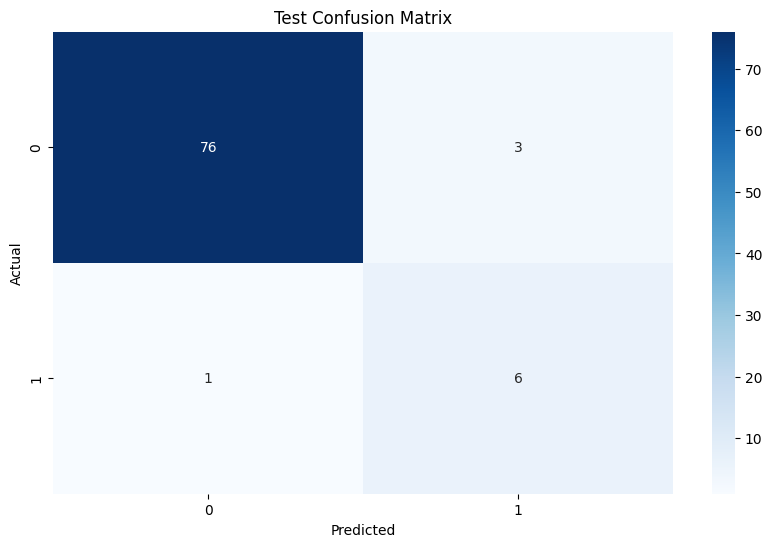

In [57]:
# Plot the Test set Confusion Matrix
test_cm= confusion_matrix(y_test, y_test_pred)

plt.figure(figsize= (10,6))
sns.heatmap(test_cm, annot= True, fmt= 'd', cmap= 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.show()

**Test Confusion Matrix**

The test confusion matrix shows that the model performs well overall, but there is still room for improvement in detecting the positive class. Specifically, the model correctly predicts 76 out of 79 negative instances (true negatives) and misclassifies 3 as positive (false positives). For the positive class, the model correctly identifies 6 out of 7 instances (true positives) and incorrectly classifies 1 as negative (false negative). This indicates that the model is generally accurate, with a slight tendency to misclassify a small number of negative instances as positive and a very minimal error rate for the positive class. The improved performance on the positive class in the test set compared to the validation set may suggest better generalization to unseen data, but the model could still benefit from further fine-tuning, especially considering the small number of positive instances.

In [56]:
# Evaluate the model on the test set
y_test_pred= model.predict(X_test_scaled)
test_accuracy= accuracy_score(y_test, y_test_pred)
test_cr= classification_report(y_test, y_test_pred)

# Print the test evaluation metrics
print(f'Test Accuracy: {test_accuracy}')
print(f'Classification Report:\n', test_cr)

Test Accuracy: 0.9534883720930233
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.96      0.97        79
         1.0       0.67      0.86      0.75         7

    accuracy                           0.95        86
   macro avg       0.83      0.91      0.86        86
weighted avg       0.96      0.95      0.96        86



**Test Set Classiication Report**

The test classification report indicates that the model performs exceptionally well overall, achieving a high test accuracy of 95.35%. For the negative class (class 0), the model exhibits outstanding performance with a precision of 0.99, recall of 0.96, and an F1-score of 0.97. This suggests that the model correctly identifies 99% of the instances it predicts as negative and captures 96% of all actual negative instances. The high F1-score for the negative class highlights the model's strong capability in accurately predicting the majority class.

For the positive class (class 1), the model's performance, though lower than for the negative class, is still commendable given the class imbalance. It achieves a precision of 0.67, recall of 0.86, and an F1-score of 0.75. This indicates that the model correctly identifies 67% of the instances it predicts as positive and successfully captures 86% of all actual positive instances. The relatively lower precision suggests some false positives, but the high recall indicates the model is effective at detecting most positive cases.

The macro average metrics, with a precision of 0.83, recall of 0.91, and F1-score of 0.86, reflect the model's balanced performance across both classes. The weighted average metrics, with precision, recall, and F1-score all around 0.95-0.96, further confirm the model's robustness, heavily influenced by the accurate predictions for the more prevalent negative class.

**Conclusion**

This project aimed to develop a machine learning model using XGBoost to predict the likelihood of cervical cancer based on various health and demographic factors. The model demonstrated excellent performance, achieving high accuracy on both the validation and test sets. The classification reports and confusion matrices indicate that the model is particularly effective at identifying negative cases, with a slight reduction in performance for the positive cases due to class imbalance.

The high accuracy and robust performance metrics suggest that the model could be a valuable tool in early detection and diagnosis of cervical cancer, potentially aiding in reducing the disease's impact through timely intervention and treatment.